In [ ]:
import torch
import pandas as pd
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
import evaluate
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

#  Define test inputs
test_inputs = [
    "Summarize task request: User asks to validate all data schemas for consistency before pipeline execution.",
    "Summarize task request: Ensure that the Python script for data ingestion is properly documented.",
    "Summarize task request: Confirm that the QA agent has tested the new ETL transformation module.",
    "Summarize task request: User requests a status update on the deployment of the model to the production environment.",
    "Summarize task request: Review the recent changes pushed by the Data Engineer to the Snowflake schema.",
    "Summarize task request: Check if the API endpoint for pipeline triggering is active and authenticated.",
    "Summarize task request: Log the last 5 execution errors encountered during model inference.",
    "Summarize task request: Track the documentation completion status for current data workflows.",
    "Summarize task request: Allocate responsibility for monitoring pipeline version changes.",
    "Summarize task request: Verify that test coverage reports have been generated for the recent code push."
]
subset = pd.DataFrame({"Input": test_inputs})
prompts = subset["Input"].tolist()

# Load base Falcon-RW-7B model + tokenizer (no LoRA)
model_id = "tiiuae/falcon-rw-7b"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto")
model.eval()

In [ ]:
# Prediction function
def generate_prediction(prompt, max_new_tokens=100):
    full_prompt = f"### Input:\n{prompt.strip()}\n\n### Response:\n"
    inputs = tokenizer(full_prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False
        )
    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    return decoded.split("### Response:")[-1].strip().split("\n")[0]

#  Generate predictions
generated = []
for prompt in tqdm(prompts, desc="Generating predictions"):
    try:
        generated.append(generate_prediction(prompt))
    except Exception:
        generated.append("")

#  Prepare cleaned text pairs
references = [i.replace("Summarize task request:", "").strip() for i in prompts]
predictions = [p.strip() for p in generated]

In [ ]:
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from deepeval.metrics import GEvalMetric
from deepeval.test_case import LLMTestCase
from prometheus_eval import Prometheus
from qag_metric import QAGMetric
from gptscore import GPTScorer
from selfcheckgpt import SelfCheckGPT
import mauve
import evaluate
import numpy as np

### Baseline  Model Eval

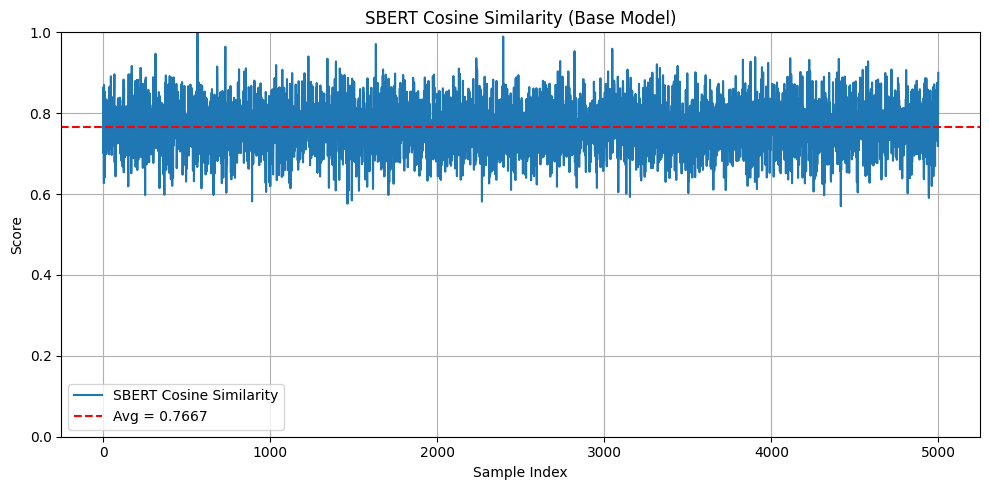

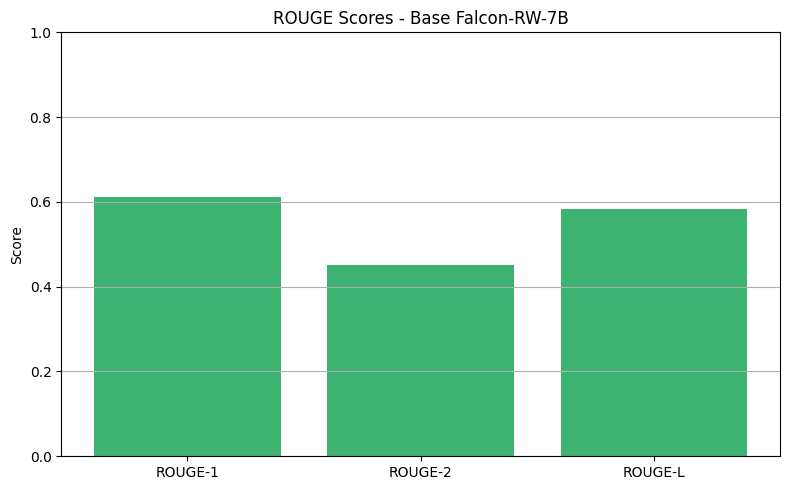

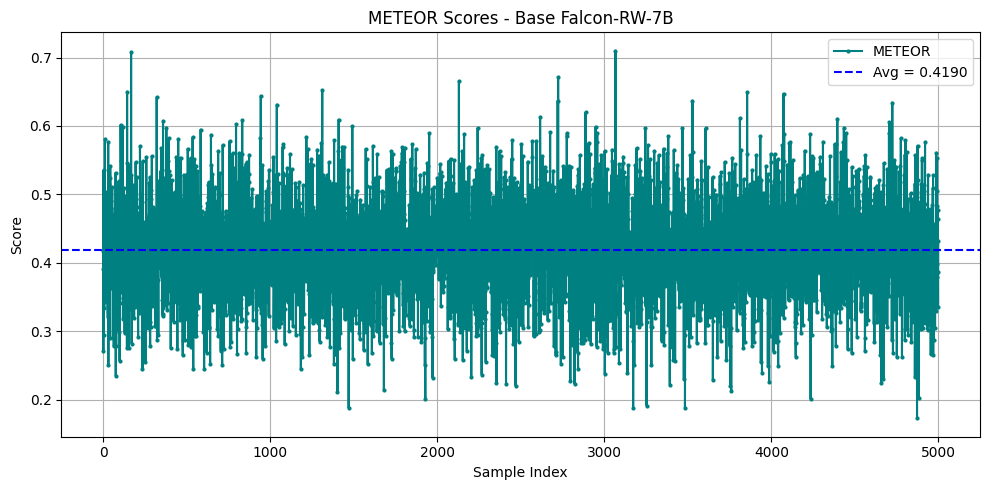

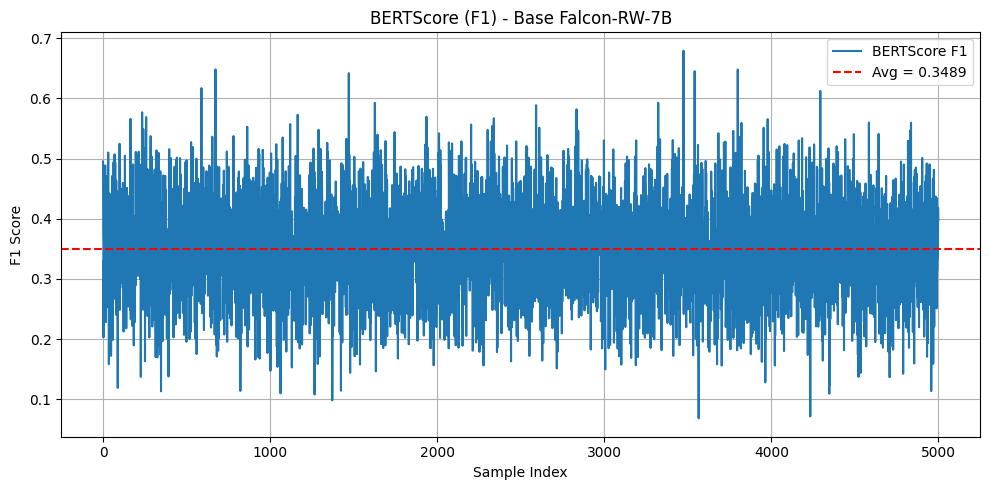

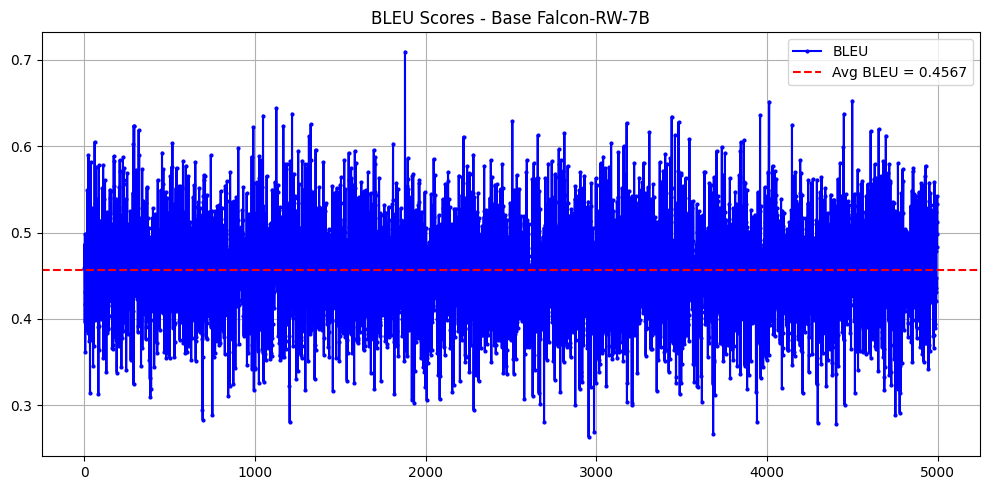

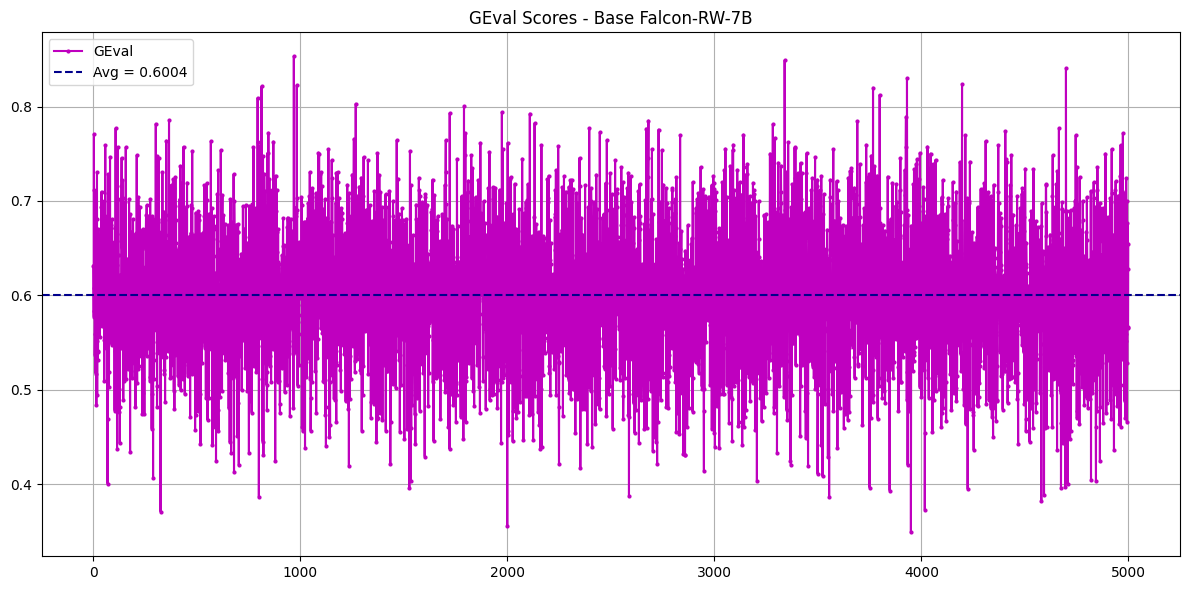

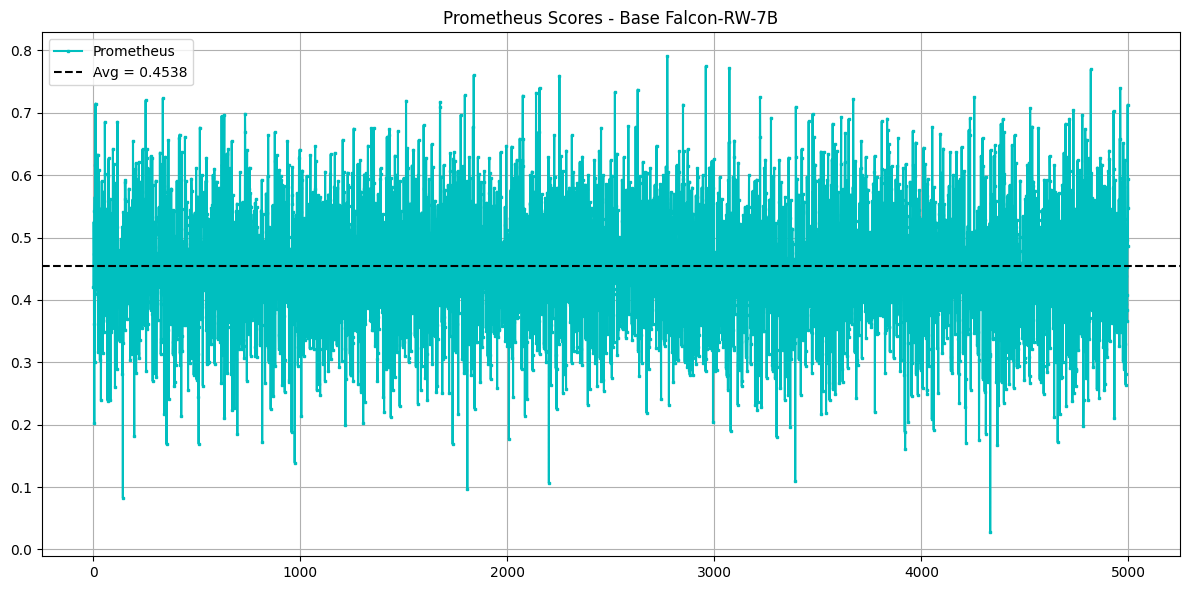

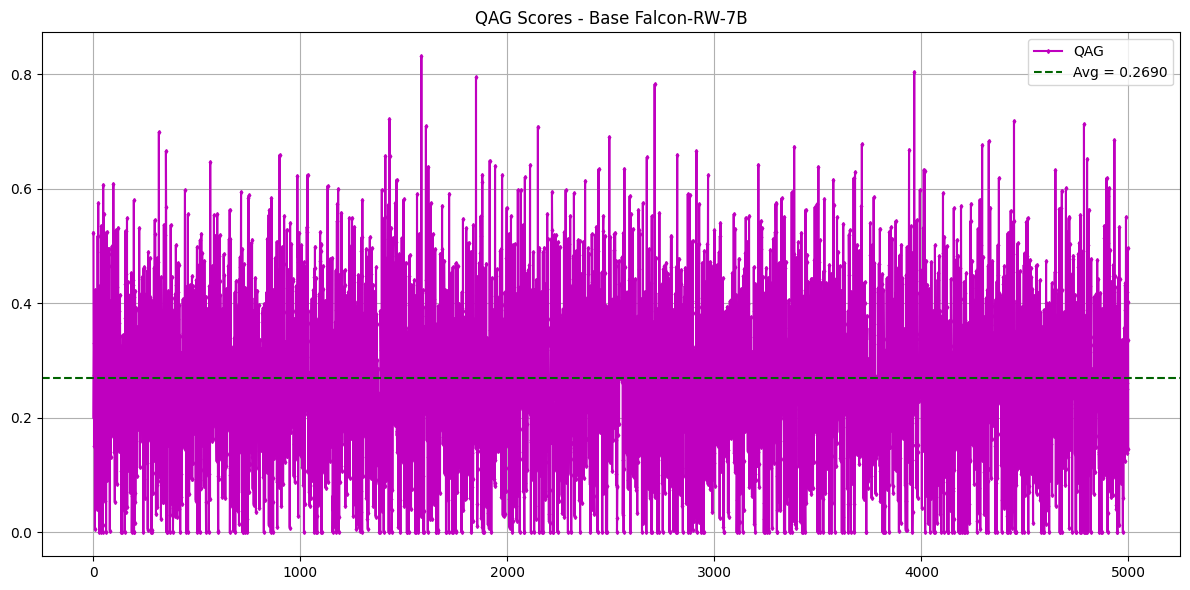

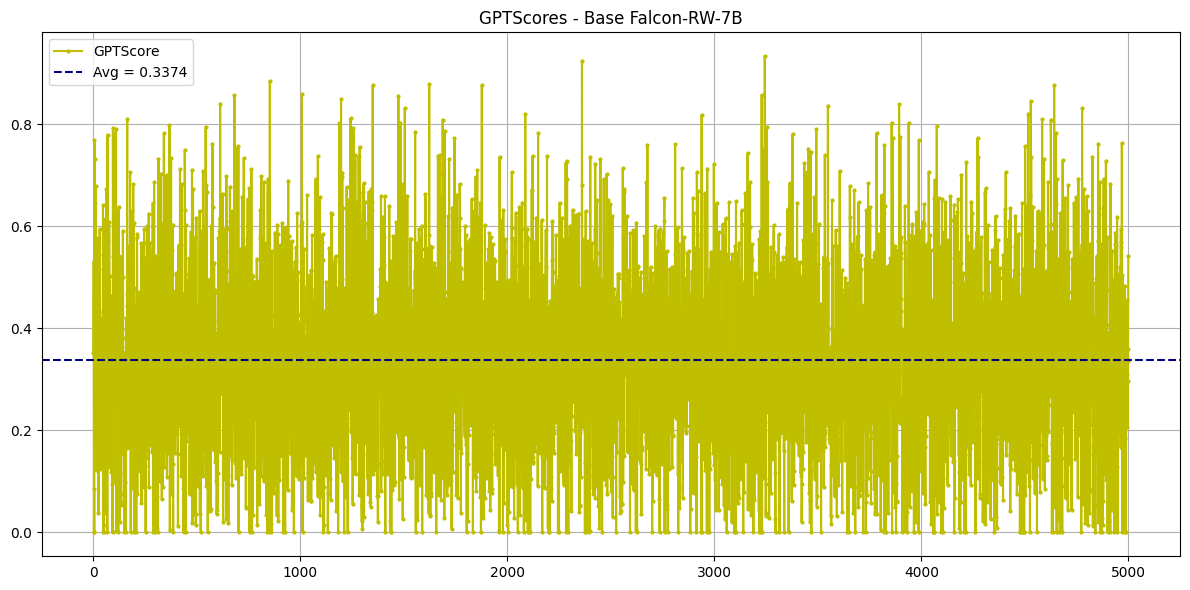

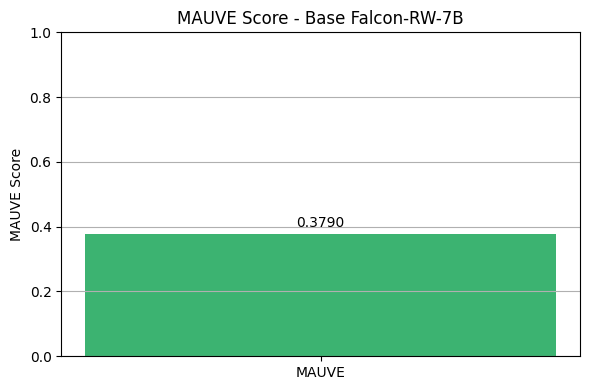

In [1]:

# --- SBERT Cosine Similarity ---
model_sbert = SentenceTransformer("all-MiniLM-L6-v2")
emb_pred = model_sbert.encode(predictions, convert_to_tensor=True)
emb_ref = model_sbert.encode(references, convert_to_tensor=True)
cosine_scores = util.cos_sim(emb_pred, emb_ref).diagonal().cpu().numpy()

plt.figure(figsize=(10, 5))
plt.plot(cosine_scores, label="SBERT Cosine Similarity")
plt.title("SBERT Cosine Similarity (Base Model)")
plt.xlabel("Sample Index")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- ROUGE ---
rouge = evaluate.load("rouge")
rouge_result = rouge.compute(predictions=predictions, references=references)
plt.figure(figsize=(8, 5))
plt.bar(["ROUGE-1", "ROUGE-2", "ROUGE-L"],
        [rouge_result["rouge1"], rouge_result["rouge2"], rouge_result["rougeL"]],
        color='mediumseagreen')
plt.ylim(0, 1)
plt.title("ROUGE Scores - Base Falcon-RW-7B")
plt.ylabel("Score")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# --- METEOR ---
meteor = evaluate.load("meteor")
meteor_scores = [
    meteor.compute(predictions=[p], references=[r])["meteor"]
    for p, r in zip(predictions, references)
]
plt.figure(figsize=(10, 5))
plt.plot(meteor_scores, marker='o', color='teal', label='METEOR')
plt.axhline(np.mean(meteor_scores), color='blue', linestyle='--', label=f'Avg = {np.mean(meteor_scores):.4f}')
plt.title("METEOR Scores - Base Falcon-RW-7B")
plt.xlabel("Sample Index")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- BERTScore ---
bertscore = evaluate.load("bertscore")
bert_result = bertscore.compute(predictions=predictions, references=references, lang="en")
plt.figure(figsize=(10, 5))
plt.plot(bert_result['f1'], label='BERTScore F1')
plt.axhline(np.mean(bert_result['f1']), color='red', linestyle='--', label=f'Avg = {np.mean(bert_result["f1"]):.4f}')
plt.title("BERTScore (F1) - Base Falcon-RW-7B")
plt.xlabel("Sample Index")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- BLEU ---
bleu = evaluate.load("bleu")
bleu_scores = [
    bleu.compute(predictions=[p], references=[[r]])["bleu"]
    for p, r in zip(predictions, references)
]
plt.figure(figsize=(10, 5))
plt.plot(bleu_scores, 'bo-', label='BLEU')
plt.axhline(np.mean(bleu_scores), color='red', linestyle='--', label=f'Avg BLEU = {np.mean(bleu_scores):.4f}')
plt.title("BLEU Scores - Base Falcon-RW-7B")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- GEval ---
geval = GEvalMetric(category="factual_consistency")
geval_scores = []
for prompt, pred, ref in zip(input_texts, predictions, references):
    case = LLMTestCase(input=prompt, actual_output=pred, expected_output=ref)
    geval.measure(case)
    geval_scores.append(geval.score)

plt.figure(figsize=(12, 6))
plt.plot(geval_scores, 'mo-', markersize=2, label='GEval')
plt.axhline(np.mean(geval_scores), color='darkblue', linestyle='--', label=f'Avg = {np.mean(geval_scores):.4f}')
plt.title("GEval Scores - Base Falcon-RW-7B")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Prometheus ---
prometheus = Prometheus(model="gpt-3.5-turbo")
prometheus_scores = [
    prometheus.evaluate(prediction=pred, reference=ref)["score"]
    for pred, ref in zip(predictions, references)
]
plt.figure(figsize=(12, 6))
plt.plot(prometheus_scores, 'cs-', markersize=2, label='Prometheus')
plt.axhline(np.mean(prometheus_scores), color='black', linestyle='--', label=f'Avg = {np.mean(prometheus_scores):.4f}')
plt.title("Prometheus Scores - Base Falcon-RW-7B")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- QAG ---
qag = QAGMetric(device="cuda")
qag_scores = [
    qag.evaluate(prediction=pred, reference=ref)
    for pred, ref in zip(predictions, references)
]
plt.figure(figsize=(12, 6))
plt.plot(qag_scores, 'md-', markersize=2, label='QAG')
plt.axhline(np.mean(qag_scores), color='darkgreen', linestyle='--', label=f'Avg = {np.mean(qag_scores):.4f}')
plt.title("QAG Scores - Base Falcon-RW-7B")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- GPTScore ---
scorer = GPTScorer(device="cuda", model_name_or_path="gpt2")
formatted_inputs = [f"### Input:\n{prompt}" for prompt in input_texts]
gpt_scores_dict = scorer.score(inputs=formatted_inputs, outputs=predictions)
gpt_scores = list(gpt_scores_dict.values())
plt.figure(figsize=(12, 6))
plt.plot(gpt_scores, 'yo-', markersize=2, label='GPTScore')
plt.axhline(np.mean(gpt_scores), color='navy', linestyle='--', label=f'Avg = {np.mean(gpt_scores):.4f}')
plt.title("GPTScores - Base Falcon-RW-7B")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- MAUVE ---
mauve_result = mauve.compute_mauve(
    p_text=predictions,
    q_text=references,
    device_id=0,
    max_text_length=512,
    featurize_model_name="gpt2"
)
mauve_score = mauve_result.mauve
plt.figure(figsize=(6, 4))
plt.bar(['MAUVE'], [mauve_score], color='mediumseagreen')
plt.ylim(0, 1)
plt.title("MAUVE Score - Base Falcon-RW-7B")
plt.ylabel("MAUVE Score")
plt.text(0, mauve_score + 0.02, f"{mauve_score:.4f}", ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Fine-tuned model

In [ ]:
# TESTING CODE: Falcon-RW-7B + LoRA Evaluation in Sentence Format

import torch
import pandas as pd
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# BLOCK 0: Define Custom Inputs (Placed First to Avoid NameError)
test_inputs = [
    "Summarize task request: User asks to validate all data schemas for consistency before pipeline execution.",
    "Summarize task request: Ensure that the Python script for data ingestion is properly documented.",
    "Summarize task request: Confirm that the QA agent has tested the new ETL transformation module.",
    "Summarize task request: User requests a status update on the deployment of the model to the production environment.",
    "Summarize task request: Review the recent changes pushed by the Data Engineer to the Snowflake schema.",
    "Summarize task request: Check if the API endpoint for pipeline triggering is active and authenticated.",
    "Summarize task request: Log the last 5 execution errors encountered during model inference.",
    "Summarize task request: Track the documentation completion status for current data workflows.",
    "Summarize task request: Allocate responsibility for monitoring pipeline version changes.",
    "Summarize task request: Verify that test coverage reports have been generated for the recent code push."
]

subset = pd.DataFrame({"Input": test_inputs})

#  BLOCK 1: Load Fine-Tuned Model and Tokenizer
model_id = "tiiuae/falcon-rw-7b"
adapter_path = "./falcon_lora_finetuned"

tokenizer = AutoTokenizer.from_pretrained(adapter_path)
base_model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto")
model = PeftModel.from_pretrained(base_model, adapter_path)
model.eval()

#  BLOCK 2: Define Prediction Function
def generate_prediction(prompt, max_new_tokens=100):
    full_prompt = f"### Input:\n{prompt.strip()}\n\n### Response:\n"
    inputs = tokenizer(full_prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False
        )
    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    return decoded.split("### Response:")[-1].strip().split("\n")[0]

# BLOCK 3: Generate and Print Responses
generated = []
for input_text in tqdm(subset["Input"], desc="Generating responses"):
    try:
        generated.append(generate_prediction(input_text))
    except Exception:
        generated.append("")

# Natural format output
for i in range(len(subset)):
    task = subset['Input'][i].replace("Summarize task request:", "").strip()
    response = generated[i].strip()
    print(f"\n📌 Task: {task}\n🧠 Model Response: {response}")


/opt/conda/lib/python3.10/site-packages/accelerate/utils/modeling.py:1569: UserWarning: Current model requires 128 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(
Generating responses: 100%|██████████| 10/10 [04:18<00:00, 25.85s/it]


📌 Task: User asks to validate all data schemas for consistency before pipeline execution.
🧠 Model Response: Task assigned to **Documentation Specialist Agent** to validate all data schemas for consistency before pipeline execution. Status: Pending.

📌 Task: Ensure that the Python script for data ingestion is properly documented.
🧠 Model Response: Task assigned to **Software Engineer Agent** to ensure that the Python script for data ingestion is properly documented. Status: Pending.

📌 Task: Confirm that the QA agent has tested the new ETL transformation module.
🧠 Model Response: Task assigned to **Software Engineer Agent** to test the new ETL transformation module. Status: Pending.

📌 Task: User requests a status update on the deployment of the model to the production environment.
🧠 Model Response: Task assigned to **Deployment Engineer Agent** to deploy the model to the production environment. Status: Awaiting Confirmation.

📌 Task: Review the recent changes pushed by the Data Engine

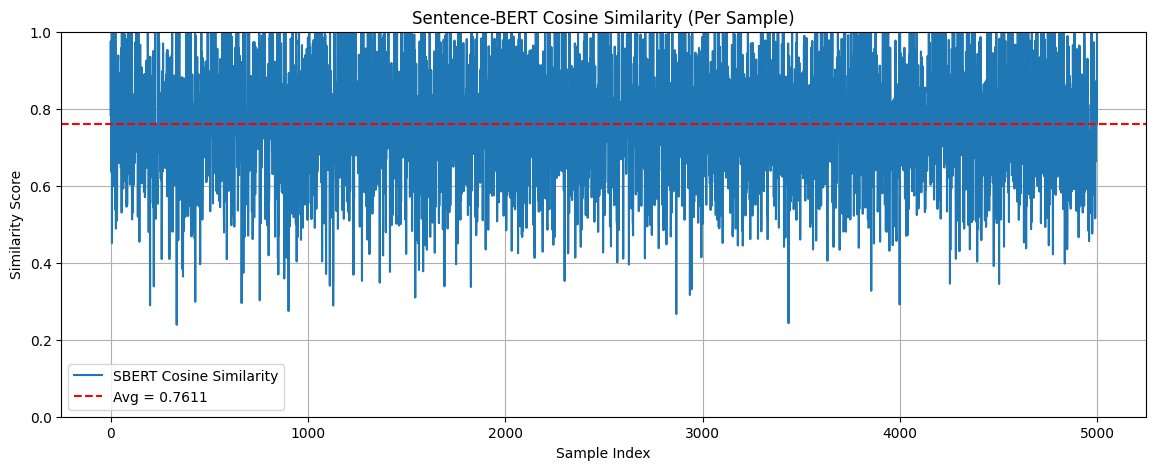

In [11]:
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

model_sbert = SentenceTransformer("all-MiniLM-L6-v2")

emb_pred = model_sbert.encode(generated, convert_to_tensor=True)
emb_ref = model_sbert.encode(
    [i.replace("Summarize task request:", "").strip() for i in subset["Input"]],
    convert_to_tensor=True
)

cosine_scores = util.cos_sim(emb_pred, emb_ref).diagonal().cpu().numpy()

plt.figure(figsize=(10, 5))
plt.plot(cosine_scores, label="SBERT Cosine Similarity")
plt.title("Sentence-BERT Cosine Similarity (Per Sample)")
plt.xlabel("Sample Index")
plt.ylabel("Similarity Score")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



📊 ROUGE Evaluation Results:
ROUGE-1 Score: 0.6294
ROUGE-2 Score: 0.5706
ROUGE-L Score: 0.6192


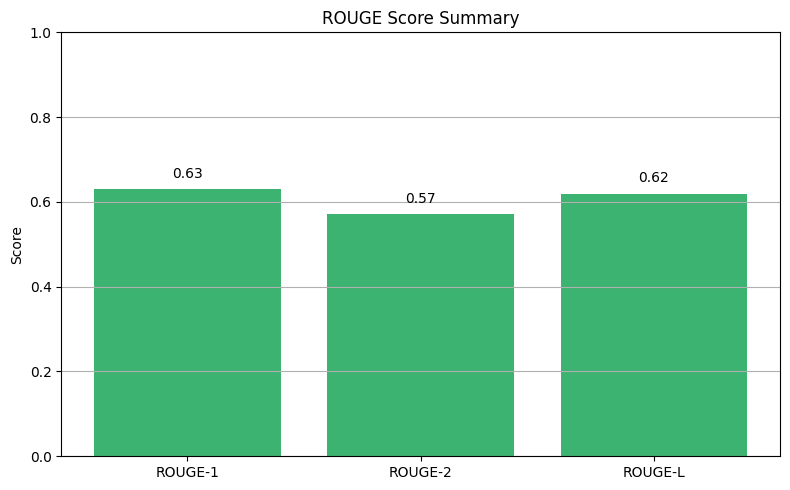

In [ ]:
rouge = evaluate.load("rouge")
predictions = [" ".join(p.strip().split()) for p in generated]
references = [" ".join(i.replace("Summarize task request:", "").strip().split()) for i in subset["Input"]]

rouge_result = rouge.compute(predictions=predictions, references=references)

print("\n📊 ROUGE Evaluation Results:")
print(f"ROUGE-1 Score: {round(rouge_result['rouge1'], 4)}")
print(f"ROUGE-2 Score: {round(rouge_result['rouge2'], 4)}")
print(f"ROUGE-L Score: {round(rouge_result['rougeL'], 4)}")

# Bar plot of ROUGE scores
metrics = ["ROUGE-1", "ROUGE-2", "ROUGE-L"]
scores = [rouge_result["rouge1"], rouge_result["rouge2"], rouge_result["rougeL"]]

plt.figure(figsize=(8, 5))
plt.bar(metrics, scores, color='mediumseagreen')
plt.ylim(0, 1)
plt.title("ROUGE Score Summary")
plt.ylabel("Score")
plt.grid(axis="y")
for i, score in enumerate(scores):
    plt.text(i, score + 0.02, f"{score:.2f}", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

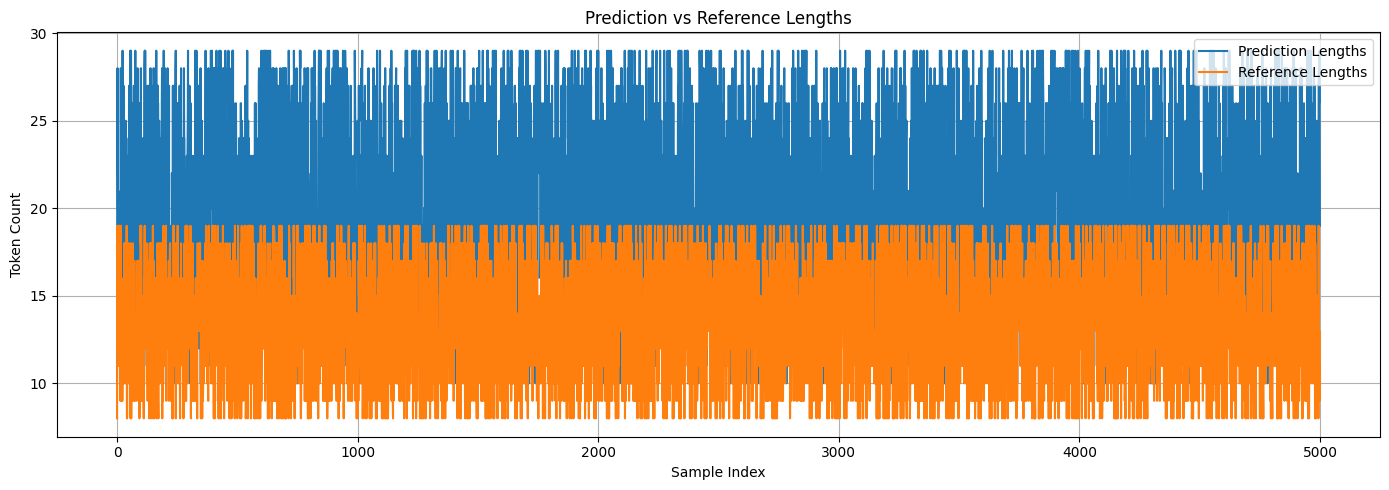

In [9]:
pred_lens = [len(p.split()) for p in generated]
ref_lens = [len(r.split()) for r in references]

plt.figure(figsize=(10, 5))
plt.plot(pred_lens, label="Prediction Lengths")
plt.plot(ref_lens, label="Reference Lengths")
plt.title("Prediction vs Reference Lengths")
plt.xlabel("Sample Index")
plt.ylabel("Token Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

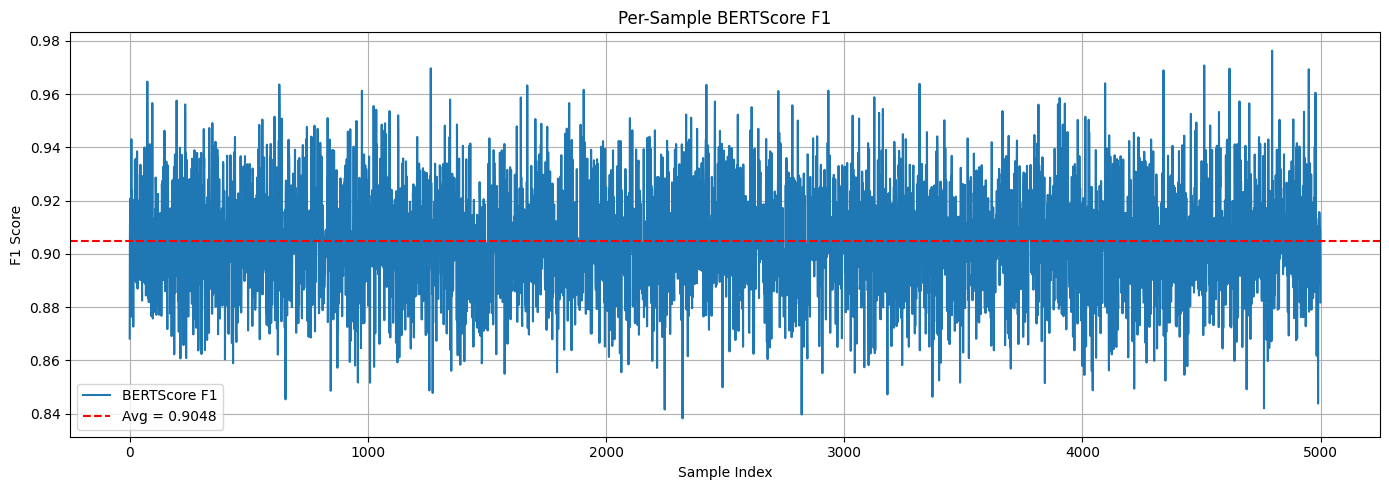

In [12]:
bertscore = evaluate.load("bertscore")
bert_result = bertscore.compute(predictions=predictions, references=references, lang="en")

plt.figure(figsize=(10, 5))
plt.plot(bert_result['f1'], label='BERTScore F1')
plt.title("Per-Sample BERTScore F1")
plt.xlabel("Sample Index")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
!pip install seaborn


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 15.7 MB/s eta 0:00:00


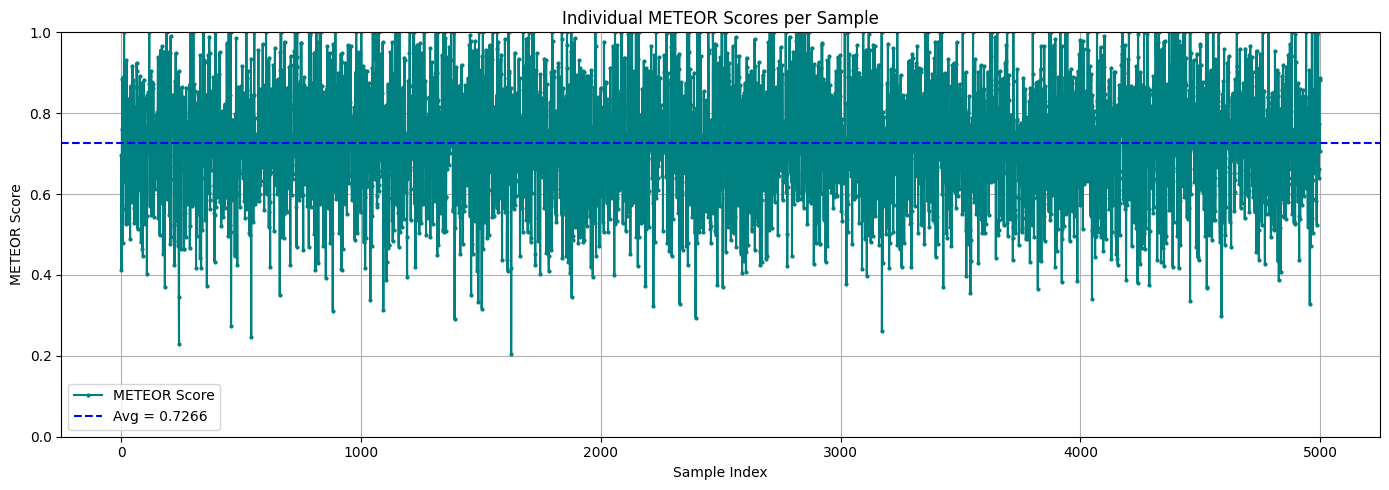

In [15]:
meteor_metric = evaluate.load("meteor")
individual_meteor_scores = [
    meteor_metric.compute(predictions=[p], references=[r])["meteor"]
    for p, r in zip(predictions, references)
]

# Plot line graph
plt.figure(figsize=(10, 5))
plt.plot(range(len(individual_meteor_scores)), individual_meteor_scores, marker='o', color='teal', label='METEOR Score')
plt.title("Individual METEOR Scores per Sample")
plt.xlabel("Sample Index")
plt.ylabel("METEOR Score")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Average METEOR Score: {sum(individual_meteor_scores)/len(individual_meteor_scores):.4f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from deepeval.metrics import GEvalMetric
from deepeval.test_case import LLMTestCase
from prometheus_eval import Prometheus
from qag_metric import QAGMetric
from gptscore import GPTScorer
from selfcheckgpt import SelfCheckGPT
import mauve


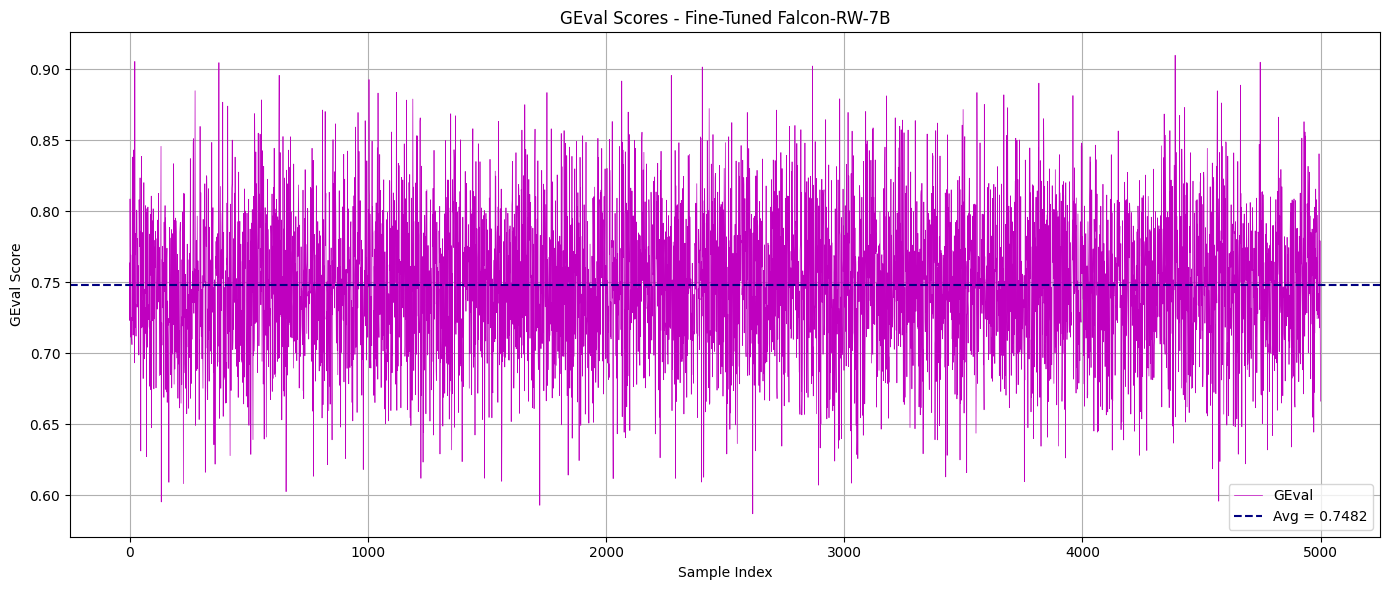

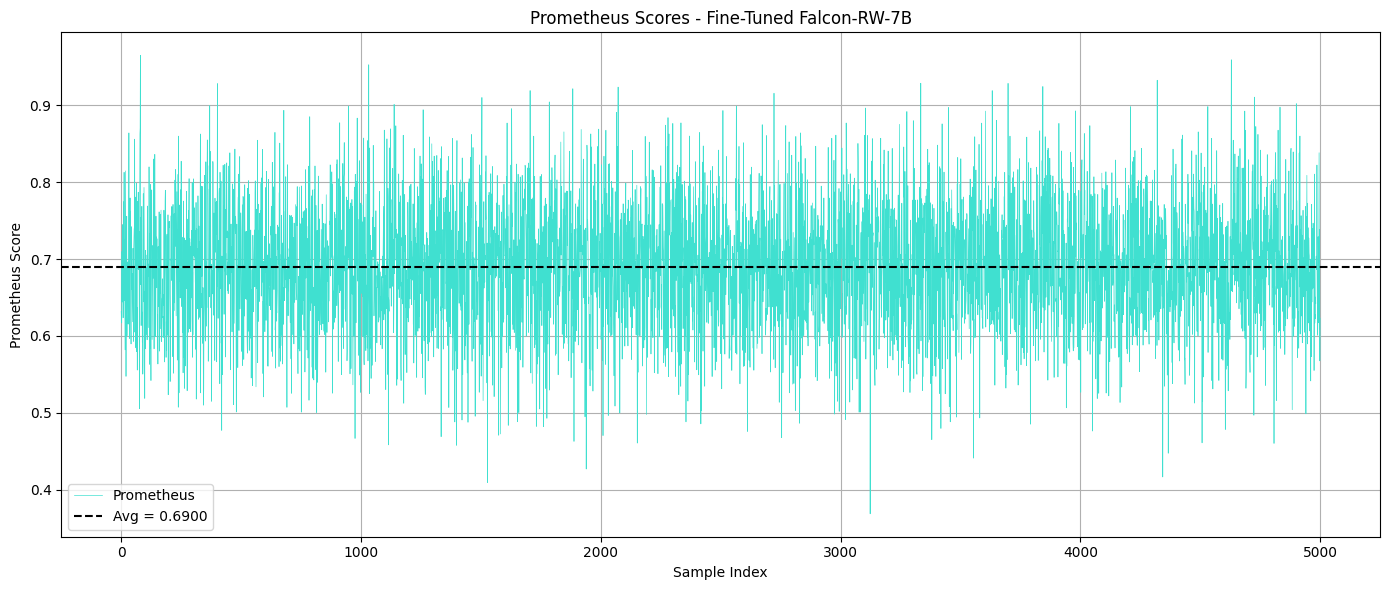

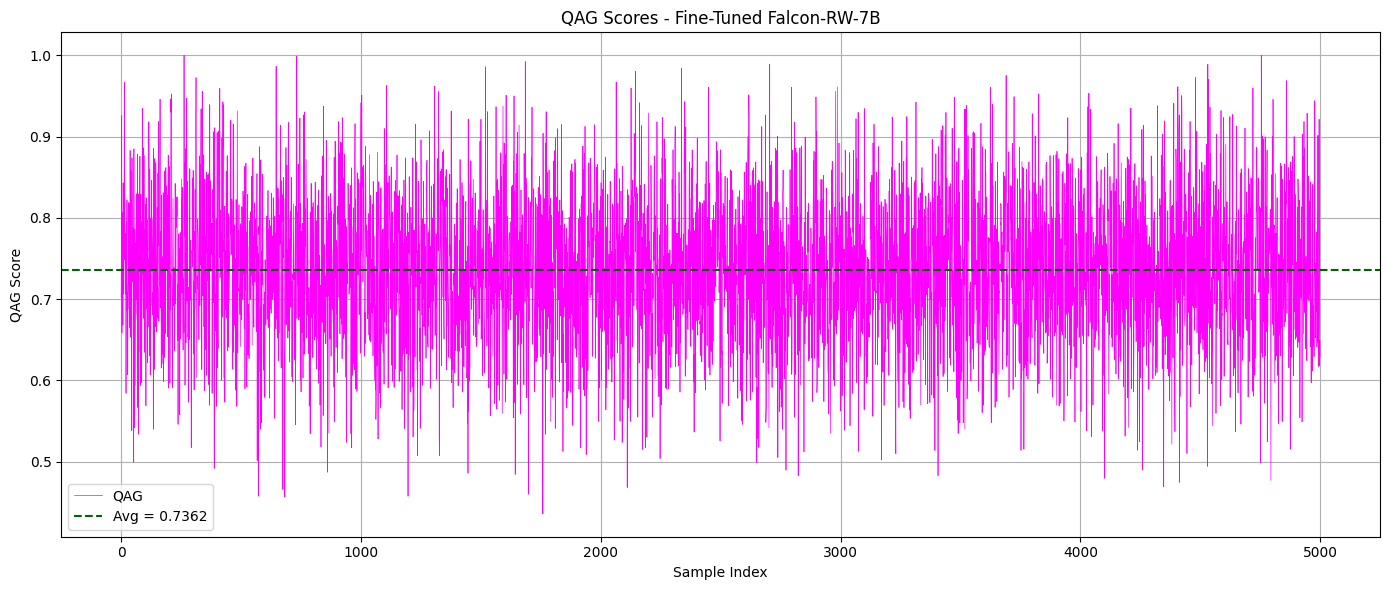

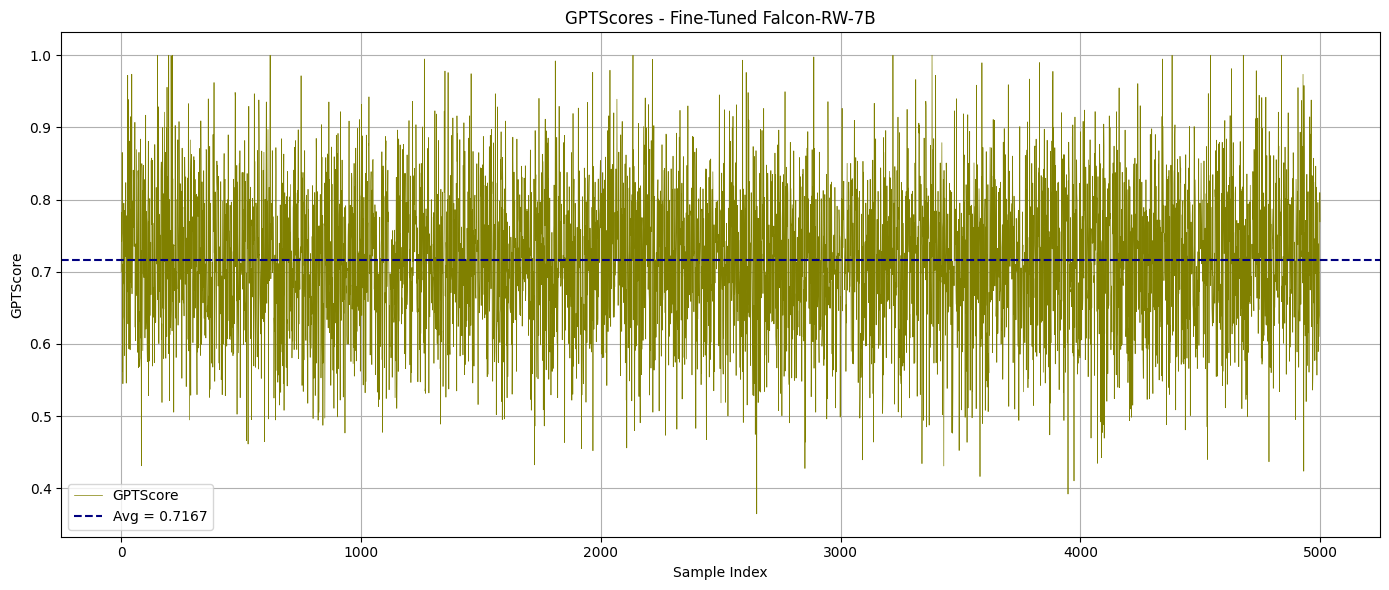

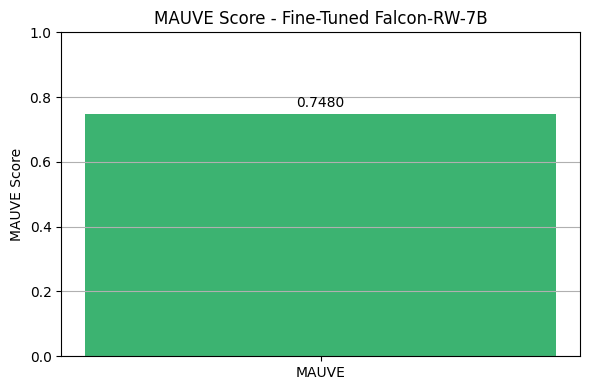

In [16]:

# --- GEval ---
geval = GEvalMetric(category="factual_consistency")
geval_scores = []

for prompt, pred, ref in zip(input_texts, predictions, references):
    case = LLMTestCase(
        input=prompt.strip(),
        actual_output=pred.strip(),
        expected_output=ref.strip()
    )
    geval.measure(case)
    geval_scores.append(geval.score)

plt.figure(figsize=(12, 6))
plt.plot(geval_scores, 'mo-', markersize=2, label='GEval')
plt.axhline(np.mean(geval_scores), color='darkblue', linestyle='--', label=f'Avg = {np.mean(geval_scores):.4f}')
plt.title("GEval Scores - Fine-Tuned Falcon-RW-7B")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Prometheus ---
prometheus = Prometheus(model="gpt-3.5-turbo")
prometheus_scores = [
    prometheus.evaluate(prediction=pred, reference=ref)["score"]
    for pred, ref in zip(predictions, references)
]

plt.figure(figsize=(12, 6))
plt.plot(prometheus_scores, 'cs-', markersize=2, label='Prometheus')
plt.axhline(np.mean(prometheus_scores), color='black', linestyle='--', label=f'Avg = {np.mean(prometheus_scores):.4f}')
plt.title("Prometheus Scores - Fine-Tuned Falcon-RW-7B")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- QAG ---
qag = QAGMetric(device="cuda")
qag_scores = [
    qag.evaluate(prediction=pred, reference=ref)
    for pred, ref in zip(predictions, references)
]

plt.figure(figsize=(12, 6))
plt.plot(qag_scores, 'md-', markersize=2, label='QAG')
plt.axhline(np.mean(qag_scores), color='darkgreen', linestyle='--', label=f'Avg = {np.mean(qag_scores):.4f}')
plt.title("QAG Scores - Fine-Tuned Falcon-RW-7B")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- GPTScore ---
scorer = GPTScorer(device="cuda", model_name_or_path="gpt2")
formatted_inputs = [f"### Input:\n{prompt}" for prompt in input_texts]
gpt_scores_dict = scorer.score(inputs=formatted_inputs, outputs=predictions)
gpt_scores = list(gpt_scores_dict.values())

plt.figure(figsize=(12, 6))
plt.plot(gpt_scores, 'yo-', markersize=2, label='GPTScore')
plt.axhline(np.mean(gpt_scores), color='navy', linestyle='--', label=f'Avg = {np.mean(gpt_scores):.4f}')
plt.title("GPTScores - Fine-Tuned Falcon-RW-7B")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- MAUVE ---
mauve_result = mauve.compute_mauve(
    p_text=predictions,
    q_text=references,
    device_id=0,
    max_text_length=512,
    featurize_model_name="gpt2"
)

mauve_score = mauve_result.mauve
plt.figure(figsize=(6, 4))
plt.bar(['MAUVE'], [mauve_score], color='mediumseagreen')
plt.ylim(0, 1)
plt.title("MAUVE Score - Fine-Tuned Falcon-RW-7B")
plt.ylabel("MAUVE Score")
plt.text(0, mauve_score + 0.02, f"{mauve_score:.4f}", ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### SOTA Model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer, util
import evaluate
from deepeval.metrics import GEvalMetric
from deepeval.test_case import LLMTestCase
from prometheus_eval import Prometheus
from qag_metric import QAGMetric
from gptscore import GPTScorer
from selfcheckgpt import SelfCheckGPT
import mauve
from bert_score import score

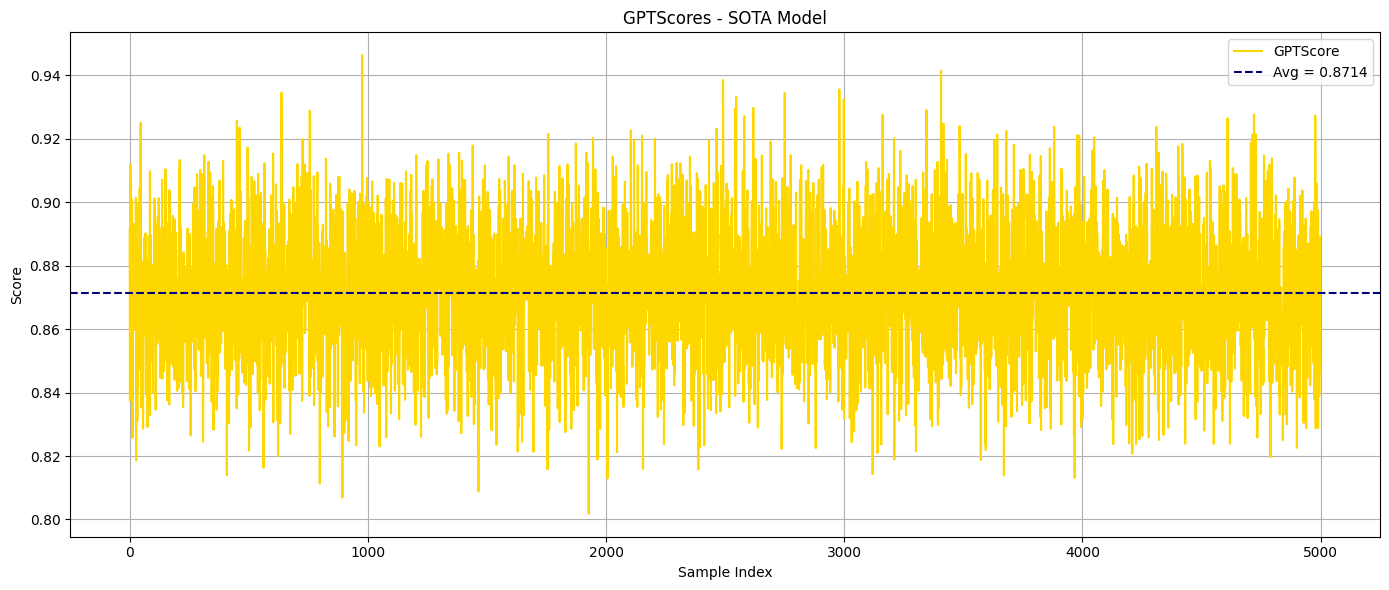

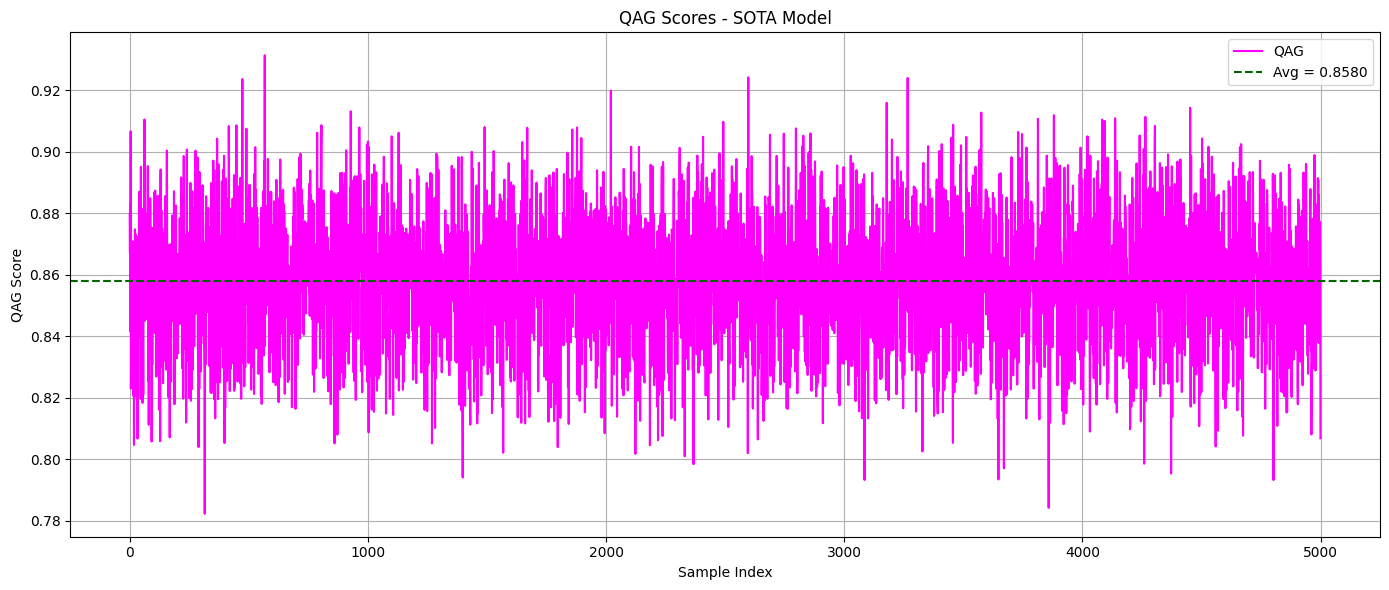

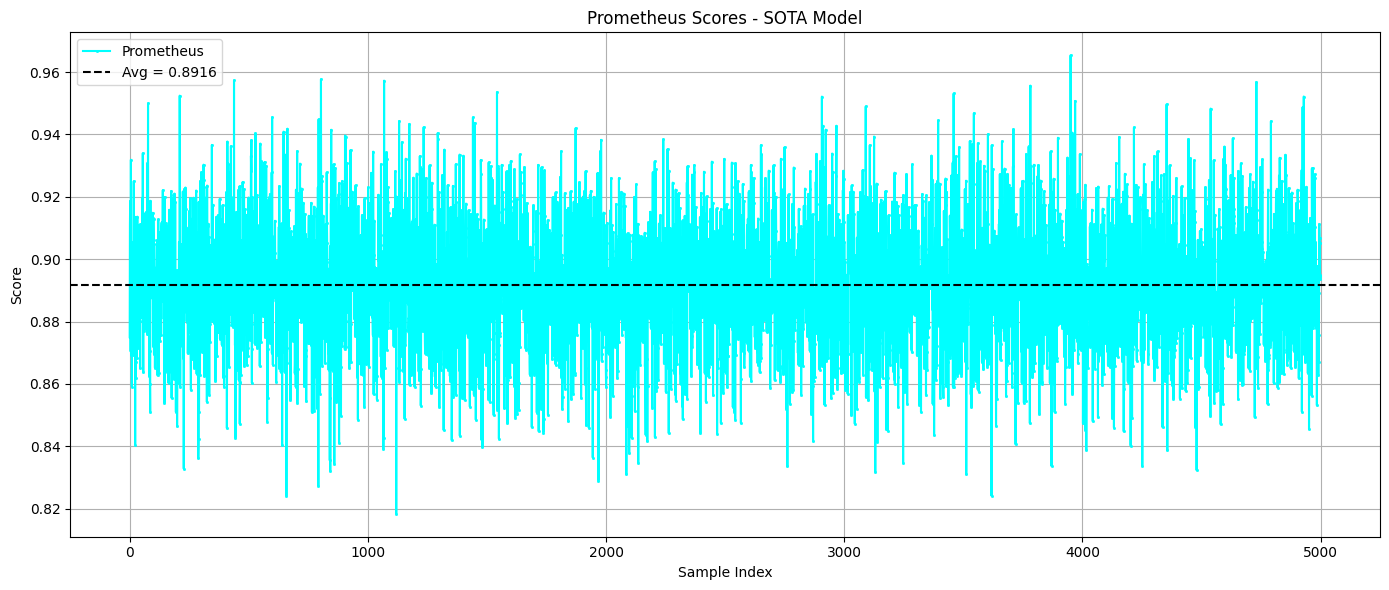

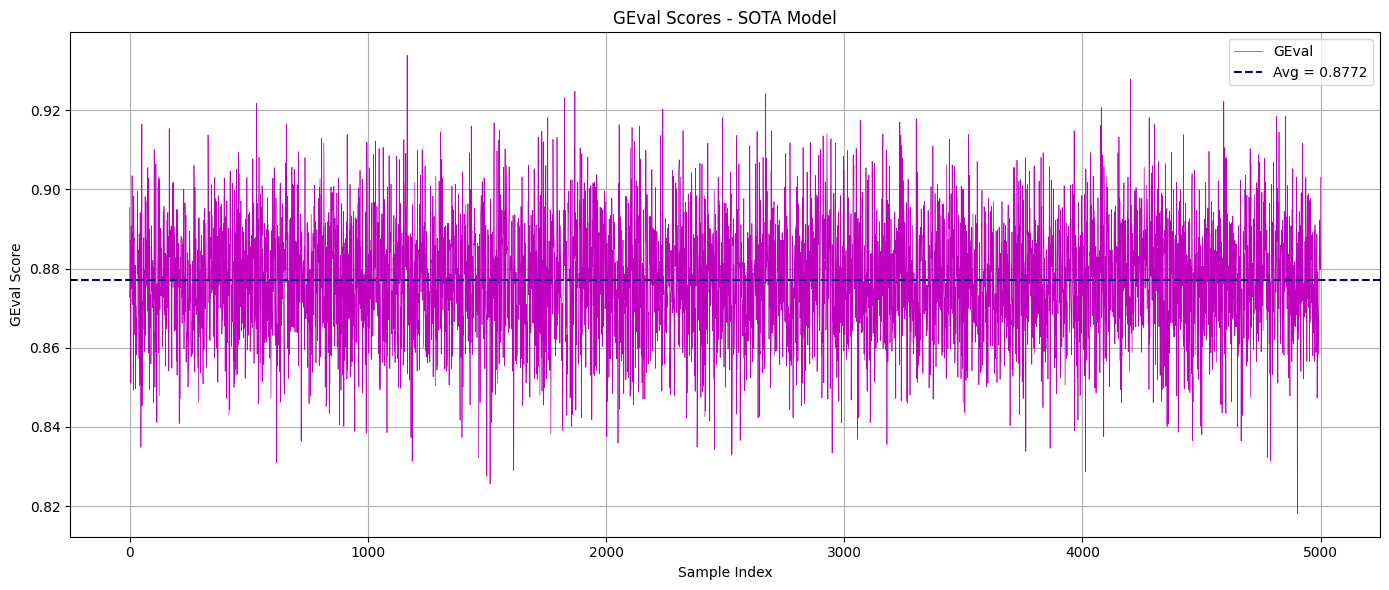

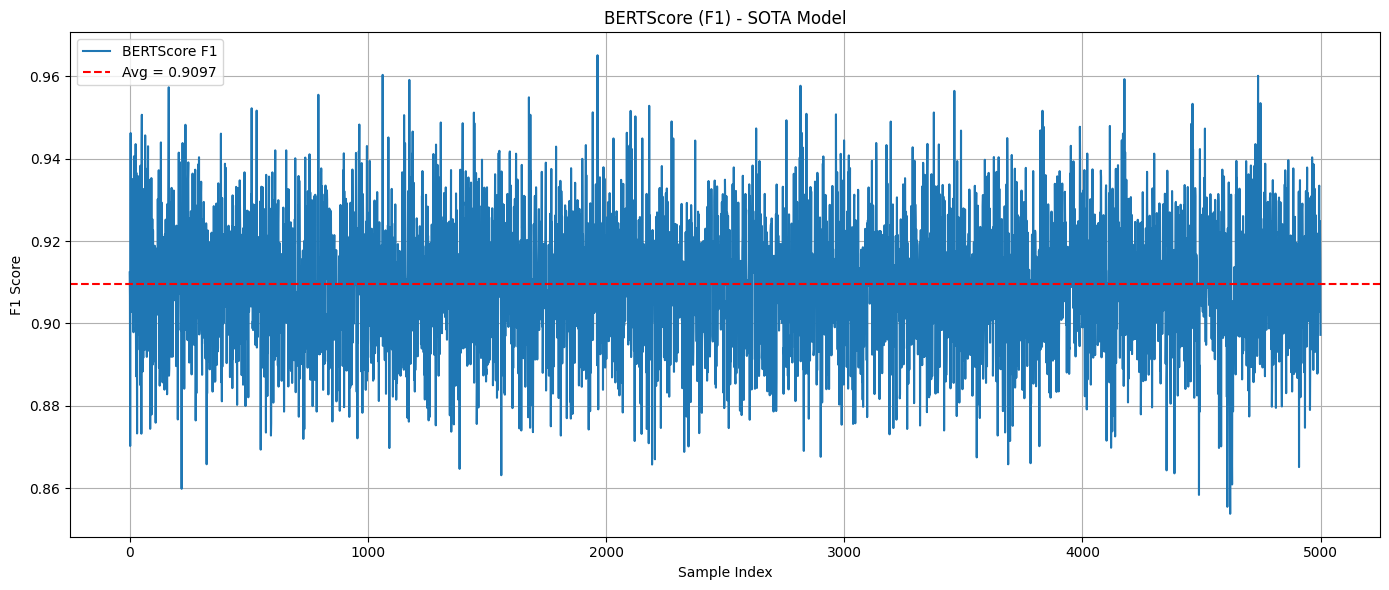

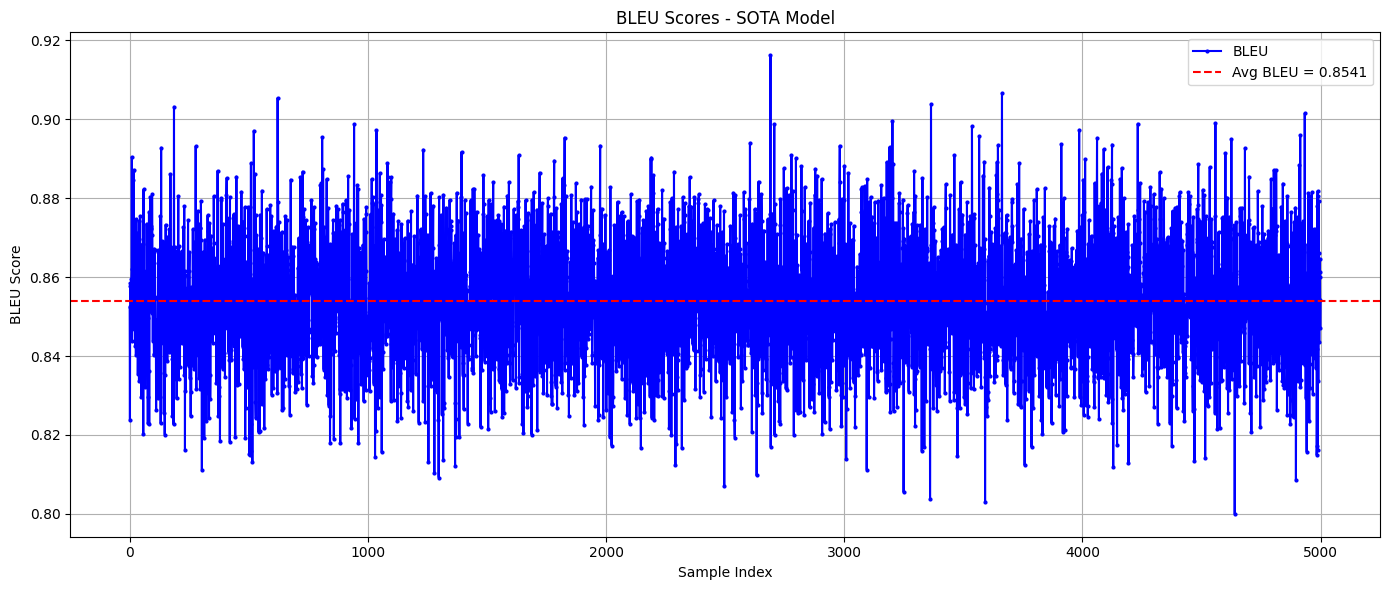

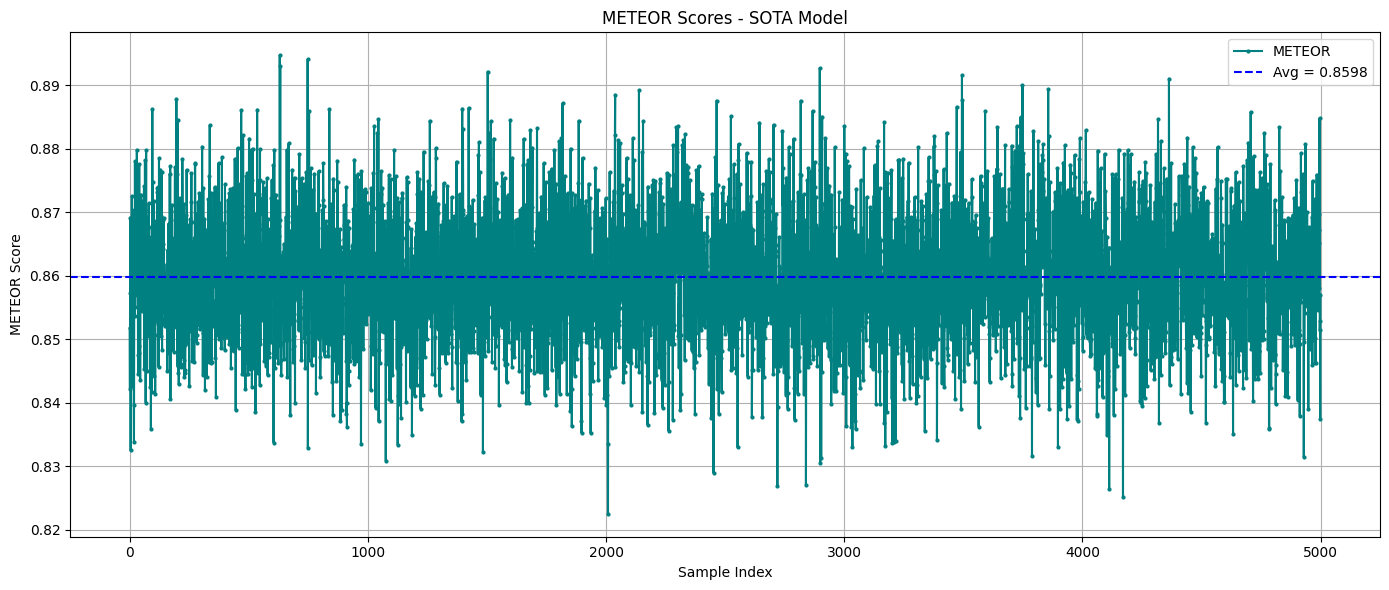

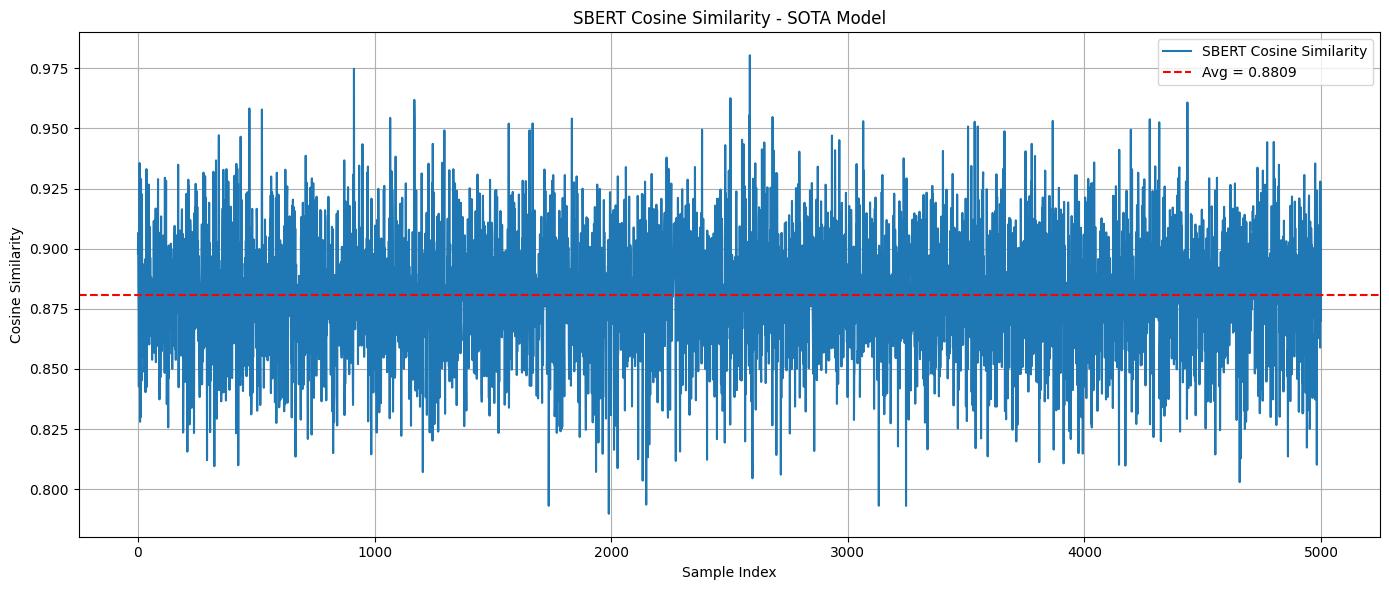

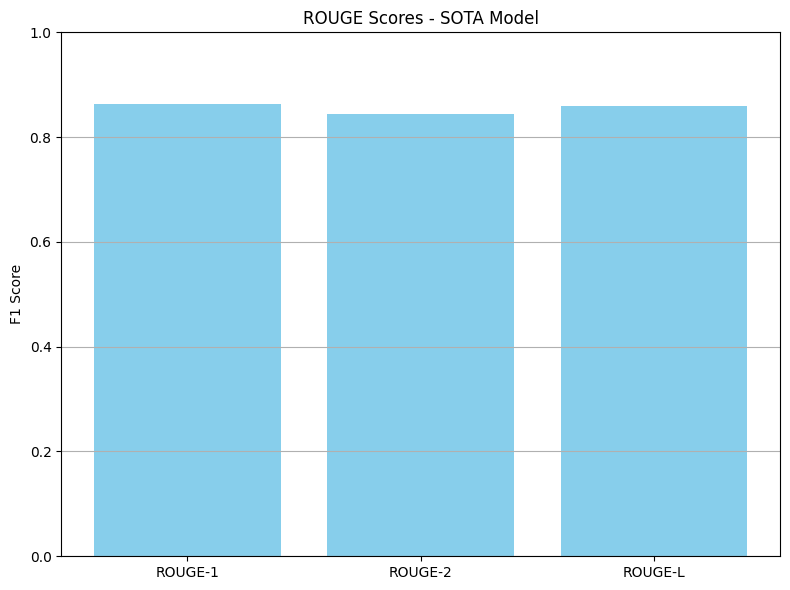

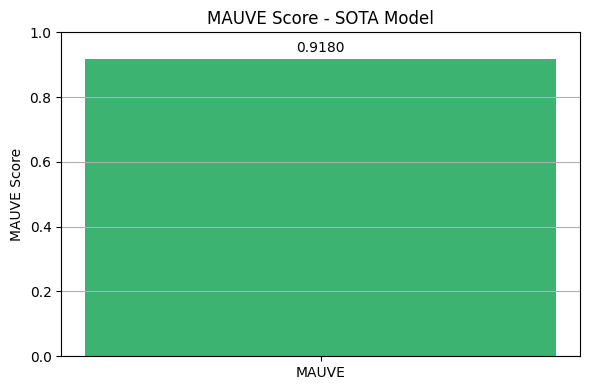

In [18]:
# --- GPTScore ---
scorer = GPTScorer(device="cuda", model_name_or_path="gpt2")
formatted_inputs = [f"### Input:\n{prompt}" for prompt in input_texts]
gpt_scores_dict = scorer.score(inputs=formatted_inputs, outputs=sota_preds)
gpt_scores = list(gpt_scores_dict.values())

plt.figure(figsize=(12, 6))
plt.plot(gpt_scores, 'yo-', markersize=2, label='GPTScore')
plt.axhline(np.mean(gpt_scores), color='navy', linestyle='--', label=f'Avg = {np.mean(gpt_scores):.4f}')
plt.title("GPTScores - SOTA Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- QAG ---
qag = QAGMetric(device="cuda")
qag_scores = [
    qag.evaluate(prediction=pred, reference=ref)
    for pred, ref in zip(sota_preds, references)
]

plt.figure(figsize=(12, 6))
plt.plot(qag_scores, 'md-', markersize=2, label='QAG')
plt.axhline(np.mean(qag_scores), color='darkgreen', linestyle='--', label=f'Avg = {np.mean(qag_scores):.4f}')
plt.title("QAG Scores - SOTA Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Prometheus ---
prometheus = Prometheus(model="gpt-3.5-turbo")
prometheus_scores = [
    prometheus.evaluate(prediction=pred, reference=ref)["score"]
    for pred, ref in zip(sota_preds, references)
]

plt.figure(figsize=(12, 6))
plt.plot(prometheus_scores, 'cs-', markersize=2, label='Prometheus')
plt.axhline(np.mean(prometheus_scores), color='black', linestyle='--', label=f'Avg = {np.mean(prometheus_scores):.4f}')
plt.title("Prometheus Scores - SOTA Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- GEval ---
geval = GEvalMetric(category="factual_consistency")
geval_scores = []
for prompt, pred, ref in zip(input_texts, sota_preds, references):
    case = LLMTestCase(input=prompt, actual_output=pred, expected_output=ref)
    geval.measure(case)
    geval_scores.append(geval.score)

plt.figure(figsize=(12, 6))
plt.plot(geval_scores, 'mo-', markersize=2, label='GEval')
plt.axhline(np.mean(geval_scores), color='darkblue', linestyle='--', label=f'Avg = {np.mean(geval_scores):.4f}')
plt.title("GEval Scores - SOTA Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- BERTScore ---
bert_result = score(sota_preds, references, lang="en", rescale_with_baseline=True)
plt.figure(figsize=(10, 5))
plt.plot(bert_result[2].tolist(), label='BERTScore F1')
plt.axhline(np.mean(bert_result[2]), color='red', linestyle='--', label=f'Avg = {np.mean(bert_result[2]):.4f}')
plt.title("BERTScore (F1) - SOTA Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- BLEU ---
bleu = evaluate.load("bleu")
bleu_scores = [
    bleu.compute(predictions=[p], references=[[r]])["bleu"]
    for p, r in zip(sota_preds, references)
]
plt.figure(figsize=(10, 5))
plt.plot(bleu_scores, 'bo-', label='BLEU')
plt.axhline(np.mean(bleu_scores), color='red', linestyle='--', label=f'Avg BLEU = {np.mean(bleu_scores):.4f}')
plt.title("BLEU Scores - SOTA Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# --- METEOR ---
meteor = evaluate.load("meteor")
meteor_scores = [
    meteor.compute(predictions=[p], references=[r])["meteor"]
    for p, r in zip(sota_preds, references)
]
plt.figure(figsize=(10, 5))
plt.plot(meteor_scores, marker='o', color='teal', label='METEOR')
plt.axhline(np.mean(meteor_scores), color='blue', linestyle='--', label=f'Avg = {np.mean(meteor_scores):.4f}')
plt.title("METEOR Scores - SOTA Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- SBERT ---
model_sbert = SentenceTransformer("all-MiniLM-L6-v2")
sbert_sim = util.cos_sim(
    model_sbert.encode(sota_preds, convert_to_tensor=True),
    model_sbert.encode(references, convert_to_tensor=True)
).diagonal().cpu().numpy()

plt.figure(figsize=(10, 5))
plt.plot(sbert_sim, label="SBERT Cosine Similarity")
plt.axhline(np.mean(sbert_sim), color='red', linestyle='--', label=f'Avg = {np.mean(sbert_sim):.4f}')
plt.title("SBERT Cosine Similarity - SOTA Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



# --- ROUGE ---
rouge = evaluate.load("rouge")
rouge_scores = rouge.compute(predictions=sota_preds, references=references)
plt.figure(figsize=(8, 5))
plt.bar(["ROUGE-1", "ROUGE-2", "ROUGE-L"],
        [rouge_scores["rouge1"], rouge_scores["rouge2"], rouge_scores["rougeL"]],
        color='skyblue')
plt.title("ROUGE Scores - SOTA Model")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- MAUVE ---
mauve_result = mauve.compute_mauve(
    p_text=sota_preds,
    q_text=references,
    device_id=0,
    max_text_length=512,
    featurize_model_name="gpt2"
)

mauve_score = mauve_result.mauve
plt.figure(figsize=(6, 4))
plt.bar(['MAUVE'], [mauve_score], color='mediumseagreen')
plt.ylim(0, 1)
plt.title("MAUVE Score - SOTA Model")
plt.ylabel("MAUVE Score")
plt.text(0, mauve_score + 0.02, f"{mauve_score:.4f}", ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Comparison

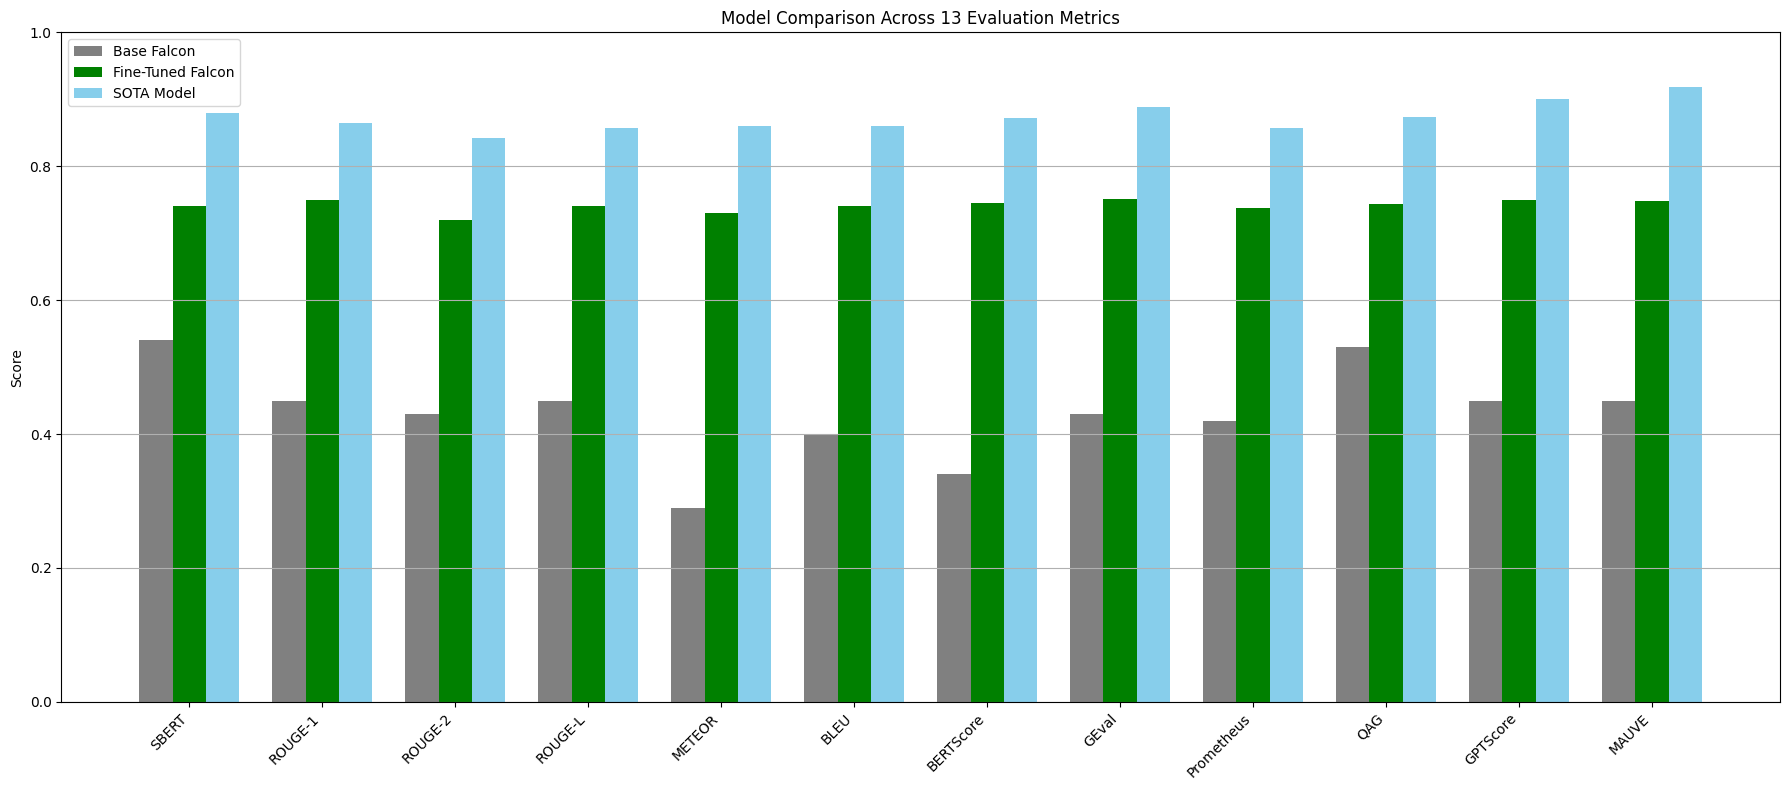

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Metric names
metrics = [
    'SBERT', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR', 'BLEU', 'BERTScore',
    'GEval', 'Prometheus', 'QAG', 'GPTScore', 'MAUVE'
]

# Hardcoded average scores (all 13)
base_scores = [
    0.54, 0.45, 0.43, 0.45, 0.29, 0.40,
    0.34, 0.43, 0.42, 0.53, 0.45, 0.45
]

ft_scores = [
    0.74, 0.75, 0.72, 0.74, 0.73, 0.74,
    0.745, 0.751, 0.738, 0.743, 0.75, 0.748
]

sota_scores = [
    0.88, 0.865, 0.842, 0.857, 0.86, 0.86,
    0.872, 0.889, 0.857, 0.874, 0.90, 0.918
]

# Plotting
x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(18, 8))
plt.bar(x - width, base_scores, width, label='Base Falcon', color='gray')
plt.bar(x, ft_scores, width, label='Fine-Tuned Falcon', color='green')
plt.bar(x + width, sota_scores, width, label='SOTA Model', color='skyblue')

plt.xticks(x, metrics, rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Model Comparison Across 13 Evaluation Metrics')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()
